## 1. Connecting to database

In [211]:
# importing required modules for connecting to pgAdmin4
import psycopg2
from sqlalchemy import create_engine

# other modules
import pandas as pd
import numpy as np
from numpy import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

from config import hostname, database, username, password, port_id

%matplotlib inline

In [190]:
try:
    conn = psycopg2.connect(
        host = hostname,
        dbname = database,
        user = username,
        password = password,
        port = port_id)
    print("Connected to the database!")

except Exception as e:
    print(f"Unable to connect to the database. Error: {e}")

Connected to the database!


In [191]:
sql_query_2 = "SELECT * FROM general_info_final"
classifier_data_2 = pd.read_sql_query(sql_query_2, conn)

C:\Users\daian\AppData\Local\Temp\ipykernel_14192\492662731.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  classifier_data_2 = pd.read_sql_query(sql_query_2, conn)


In [192]:
conn.close()

In [193]:
pd.set_option('display.max_columns', 25)
classifier_data_2.head()

,Unnamed: 0,ID,STATE,GENDER,INCOME,WEIGHT,BMI,RACE,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,SLEEP,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,STROKE,ARTHRITIS,_SMOKER3,DIFFWALK,EDUCATION,HEIGHT
0,1,1,1.0,FEMALE,3.0,6804.0,Over_Weight,White,13.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,Never,0.0,Grad_HS_Y,63.0
1,2,2,1.0,FEMALE,6.0,6350.0,Over_Weight,White,8.0,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,Never,0.0,College_Y,62.0
2,4,4,1.0,FEMALE,3.0,5398.0,Normal_Weight,White,5.0,0.0,2.0,0.0,1.0,9.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,Never,0.0,College_N,62.0
3,6,6,1.0,FEMALE,5.0,6260.0,Normal_Weight,Black,13.0,0.0,0.0,0.0,1.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,Prev_Smoker,0.0,College_Y,65.0
4,7,7,1.0,FEMALE,5.0,7348.0,Over_Weight,White,13.0,0.0,0.0,0.0,0.0,8.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,Never,0.0,Grad_HS_Y,64.0


In [194]:
classifier_data_2.groupby(['DIABETES']).size()

DIABETES
0.0    204208
1.0     34006
2.0      2137
4.0      5699
dtype: int64

* 0 = no diabetes
* 1 = diabetes
* 2 = gestational diabetes
* 4 = pre-diabetes

In [226]:
classifier_data_2.columns

Index(['GENDER', 'INCOME', 'WEIGHT', 'BMI', 'RACE', 'AGE', 'DIABETES',
       'PHYSHLTH', 'MENTHLTH', 'EXERCISE', 'HLT_INSURANCE', 'PERSONAL_DOC',
       'CHECKUP1', 'HRT_ATTACK', 'HRT_DISEASE', 'STROKE', 'ARTHRITIS',
       '_SMOKER3', 'DIFFWALK', 'EDUCATION', 'HEIGHT'],
      dtype='object')

In [195]:
# dropping the unnamed & ID columns
classifier_data_2.drop(columns=['Unnamed: 0','ID'], inplace=True)

##### Checking the correlation between features

C:\Users\daian\AppData\Local\Temp\ipykernel_14192\4186531861.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(classifier_data_2.corr(),annot=True,linewidth =2)


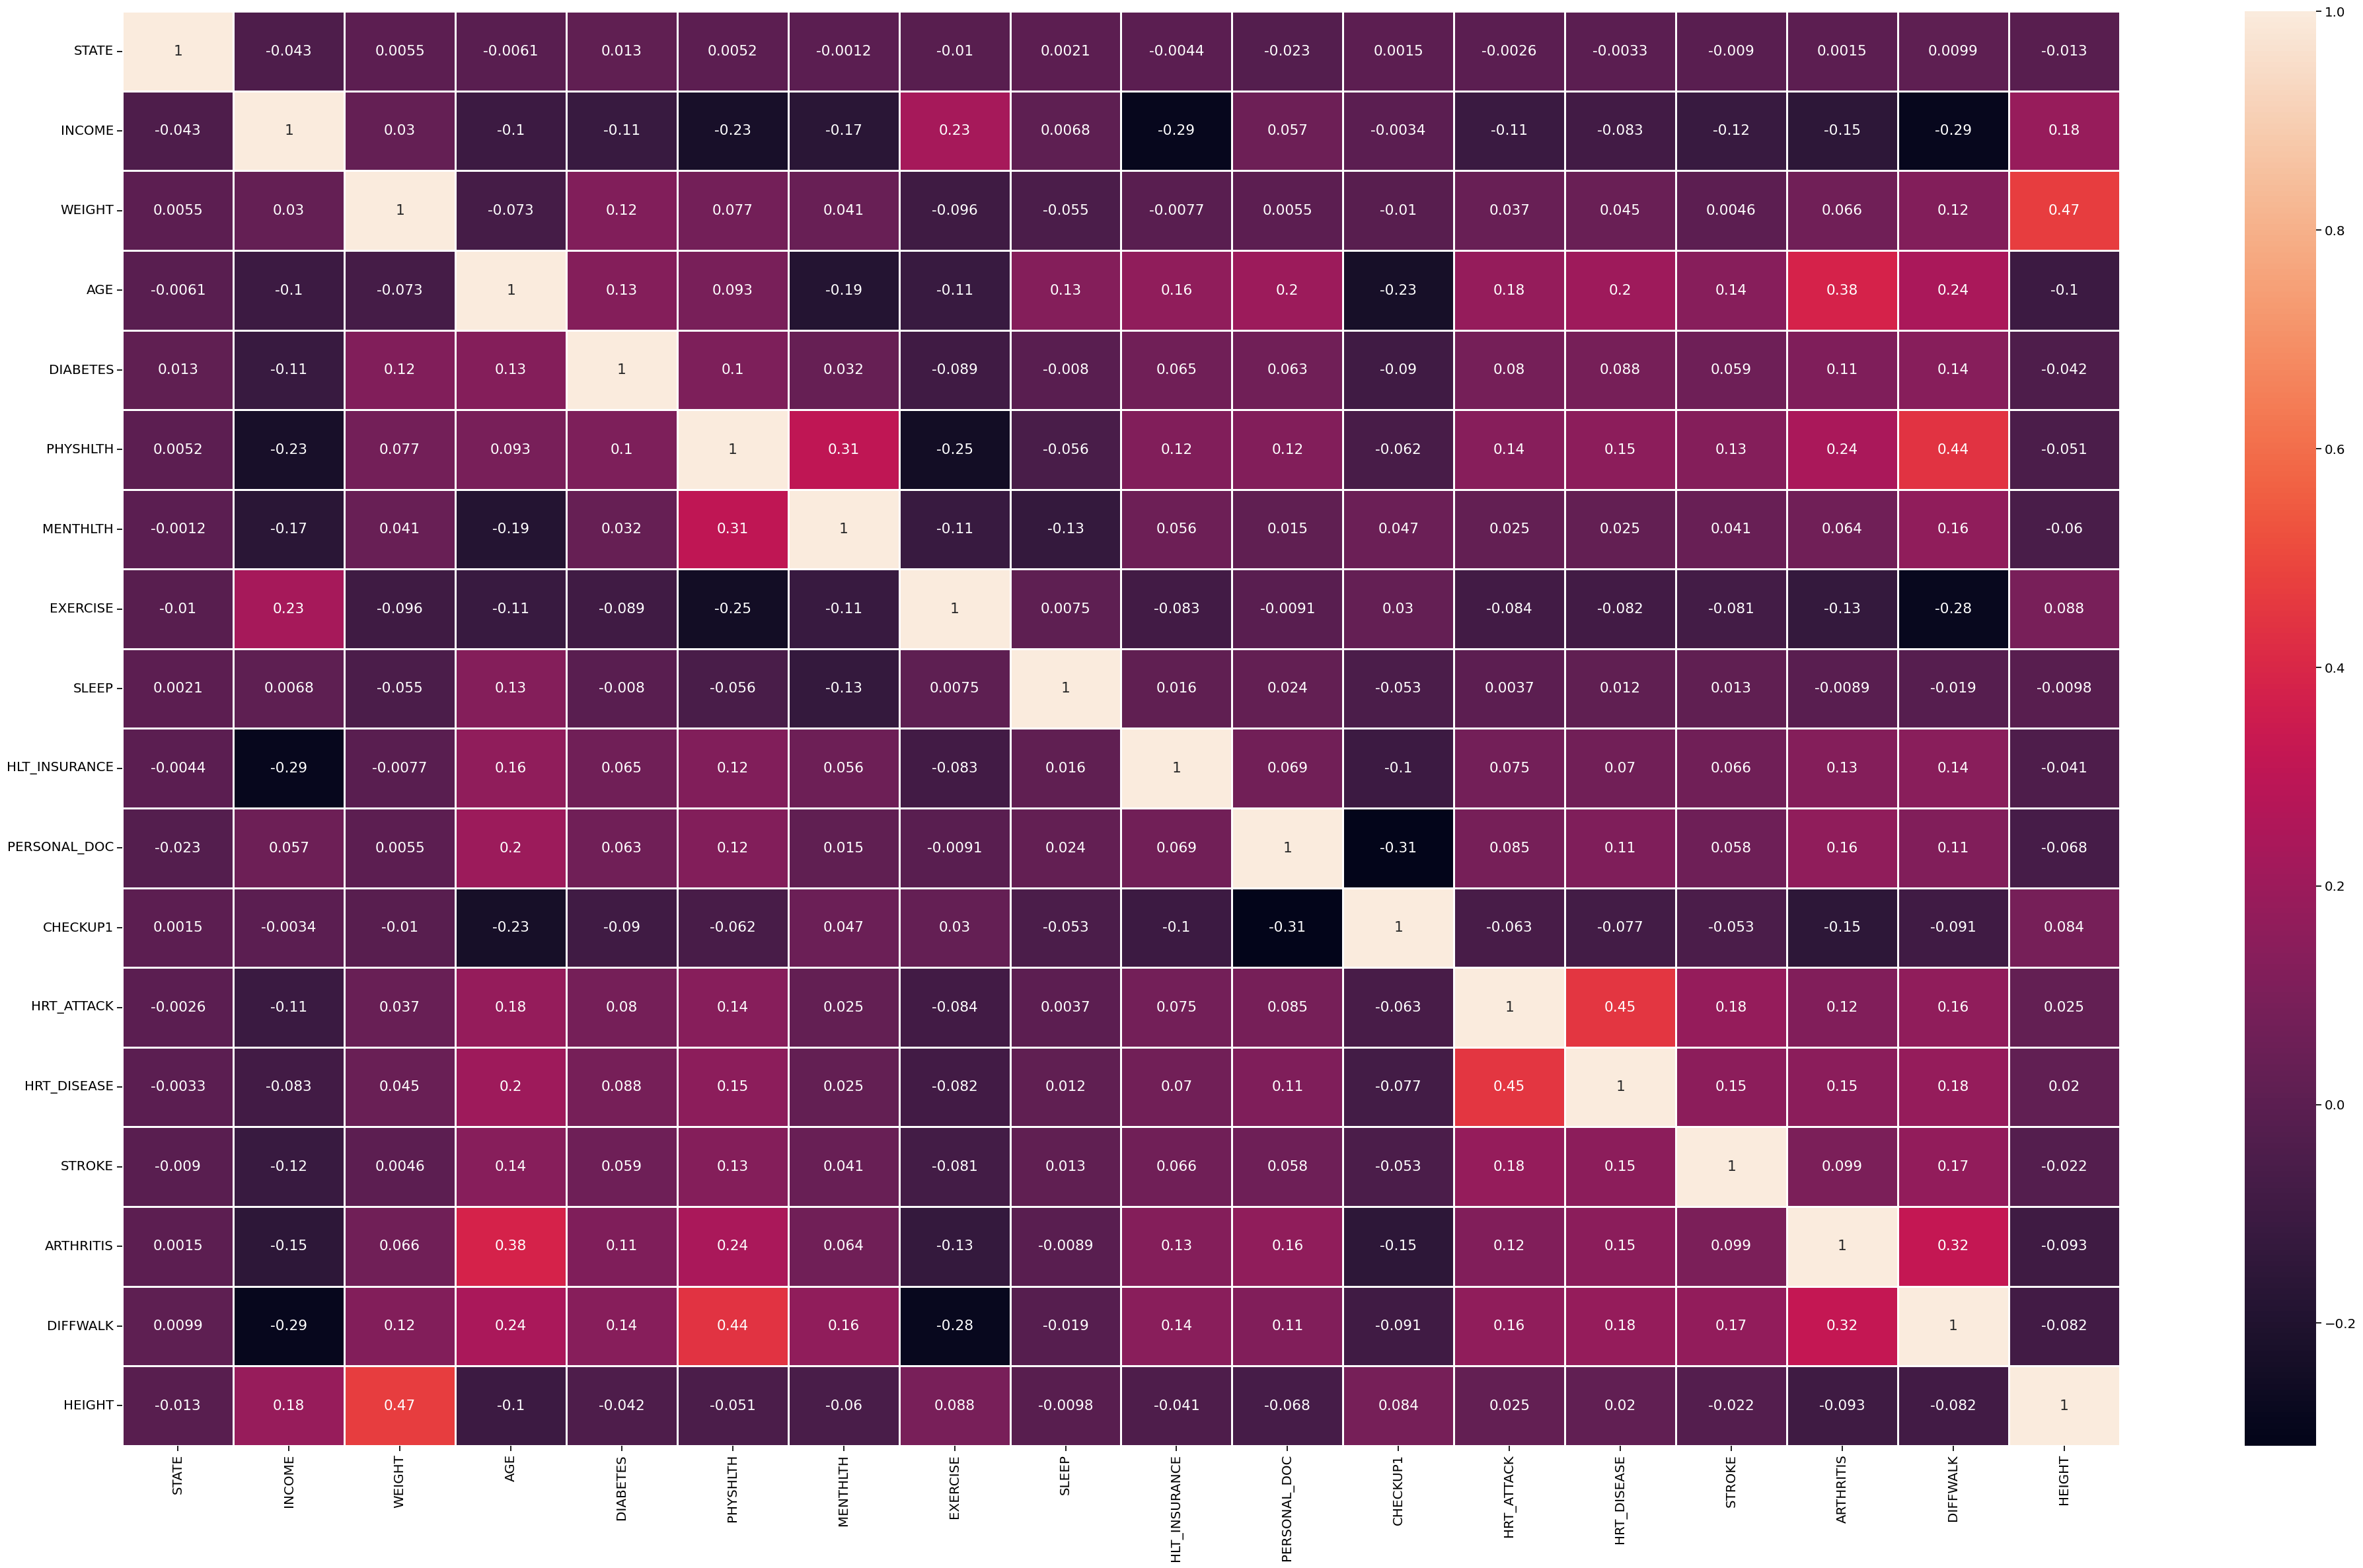

In [196]:
plt.figure(figsize=(40,24))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(classifier_data_2.corr(),annot=True,linewidth =2)
plt.tight_layout()

In [197]:
# calculate and display the correlation matrix
correlation_matrix = classifier_data_2.corr()
diabetes_corr_features = correlation_matrix['DIABETES']

C:\Users\daian\AppData\Local\Temp\ipykernel_14192\3676200247.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = classifier_data_2.corr()


In [198]:
diabetes_corr_features

STATE            0.012545
INCOME          -0.112232
WEIGHT           0.115456
AGE              0.128518
DIABETES         1.000000
PHYSHLTH         0.104078
MENTHLTH         0.032015
EXERCISE        -0.089386
SLEEP           -0.008007
HLT_INSURANCE    0.065222
PERSONAL_DOC     0.063193
CHECKUP1        -0.090279
HRT_ATTACK       0.079795
HRT_DISEASE      0.087732
STROKE           0.058638
ARTHRITIS        0.109642
DIFFWALK         0.137010
HEIGHT          -0.041721
Name: DIABETES, dtype: float64

State and sleep features have low correlation so we will drop these from the dataset.

In [199]:
cleaned_data = classifier_data_2
cleaned_data.drop(columns=['STATE','SLEEP'], inplace=True)oh v

In [200]:
cleaned_data.head()

,GENDER,INCOME,WEIGHT,BMI,RACE,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,STROKE,ARTHRITIS,_SMOKER3,DIFFWALK,EDUCATION,HEIGHT
0,FEMALE,3.0,6804.0,Over_Weight,White,13.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,Never,0.0,Grad_HS_Y,63.0
1,FEMALE,6.0,6350.0,Over_Weight,White,8.0,0.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,Never,0.0,College_Y,62.0
2,FEMALE,3.0,5398.0,Normal_Weight,White,5.0,0.0,2.0,0.0,1.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,Never,0.0,College_N,62.0
3,FEMALE,5.0,6260.0,Normal_Weight,Black,13.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,Prev_Smoker,0.0,College_Y,65.0
4,FEMALE,5.0,7348.0,Over_Weight,White,13.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,Never,0.0,Grad_HS_Y,64.0


# 2. Creating the binary dataset for predicting diabetes
1. Join prediabetes & diabetes since we want to use this as a predicition for people who could be flagged as diabetic. 
2. Balance the dataset.

In [201]:
# use get_dummies to one-hot encode the categorical columns
categorical_cols = ['GENDER','BMI','RACE','_SMOKER3','EDUCATION']
binary_df = pd.get_dummies(cleaned_data, columns=categorical_cols)

In [202]:
binary_df.head()

,INCOME,WEIGHT,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,...,RACE_Hispanic,RACE_Indian-Alaskan_Native,RACE_Multiracial,RACE_White,_SMOKER3_Never,_SMOKER3_Prev_Smoker,_SMOKER3_Smok_daily_N,_SMOKER3_Smok_daily_Y,EDUCATION_College_N,EDUCATION_College_Y,EDUCATION_Grad_HS_N,EDUCATION_Grad_HS_Y
0,3.0,6804.0,13.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0,0,1
1,6.0,6350.0,8.0,0.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,1,0,0
2,3.0,5398.0,5.0,0.0,2.0,0.0,1.0,7.0,2.0,1.0,0.0,0.0,...,0,0,0,1,1,0,0,0,1,0,0,0
3,5.0,6260.0,13.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1,0,0
4,5.0,7348.0,13.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0,0,1


In [203]:
binary_df['DIABETES'].value_counts()

0.0    204208
1.0     34006
4.0      5699
2.0      2137
Name: DIABETES, dtype: int64

In [204]:
# changing 2 & 4 to 1 so that prediabetics, gestantional diabetes & diabetics are in the same class
binary_df['DIABETES'] = binary_df['DIABETES'].replace({2:1, 4:1})
binary_df.DIABETES.value_counts()

0.0    204208
1.0     41842
Name: DIABETES, dtype: int64

Since there is class imbalance, different techniques will be used to evaluate the best data and model combination. The methods listed below will be used to deal wit the class imbalance:
1. Resampling technique
2. Using different evaluation metrics
3. Different algorithms

The follow models will be evaluated:
1. K-Nearest Neighbours
2. Random Forest
3. Deep neural networks

#### 2.1 Resampling the data to 50/50

In [205]:
# separating the 0 and 1
diabetes = binary_df[binary_df['DIABETES'] == 1]
no_diabetes = binary_df[binary_df['DIABETES'] == 0]

# next we select 41,842 random entries from the 0 group since we have 41,842 entries of the 1 group
random_diabetes_selection = no_diabetes.take(np.random.permutation(len(no_diabetes))[:41842])

new_diabetes_df = random_diabetes_selection.append(diabetes, ignore_index=True)

new_diabetes_df.head()
new_diabetes_df.tail()

new_diabetes_df['DIABETES'].value_counts()

C:\Users\daian\AppData\Local\Temp\ipykernel_14192\2481381889.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_diabetes_df = random_diabetes_selection.append(diabetes, ignore_index=True)


0.0    41842
1.0    41842
Name: DIABETES, dtype: int64

Now that we have an even 50/50 split dataset, we can use this to prepare the data for the model.

#### 2.2 Model Evaluation

In [19]:
accuracy_models = list()
precision_models = list()
F1score_models = list()
recall_models = list()
model_type = list()
resample = list()

def evaluate_model(y_test, y_pred, algo=None, sampling=None):
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix')
    print('='*60)
    print(cm)
    print('\n')
    
    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score')
    print('='*60)
    print(acc_score)
    print('\n')

    # Displaying the classification report
    cr = classification_report(y_test, y_pred)
    print('Classification Report')
    print('='*60)
    print(cr)
    print('\n')
  
    accuracy_models.append(acc_score)
    precision_models.append(precision_score(y_test,y_pred))
    recall_models.append(recall_score(y_test,y_pred))
    F1score_models.append(f1_score(y_test,y_pred))
    model_type.append(algo)
    resample.append(sampling)

In [57]:
def compute_ROC(y_test, y_predict, algo=None, sampling=None):
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {algo}-{sampling}')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_plot-{algo}-{sampling}.png')
    plt.show()

### 3. Model Building

### 3.1 Using 50/50 Split Data

In [20]:
# splitting the data into a training and testing set
target_variable = new_diabetes_df['DIABETES']
features = new_diabetes_df.drop(columns = 'DIABETES')

In [21]:
# previewing the first five entries of the features dataframe
features[:5]

,INCOME,WEIGHT,AGE,PHYSHLTH,MENTHLTH,EXERCISE,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,STROKE,...,RACE_Hispanic,RACE_Indian-Alaskan_Native,RACE_Multiracial,RACE_White,_SMOKER3_Never,_SMOKER3_Prev_Smoker,_SMOKER3_Smok_daily_N,_SMOKER3_Smok_daily_Y,EDUCATION_College_N,EDUCATION_College_Y,EDUCATION_Grad_HS_N,EDUCATION_Grad_HS_Y
0,5.0,7000.0,6.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,1,0,0
1,5.0,8165.0,8.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,0,0,1
2,2.0,6350.0,10.0,0.0,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,0,1,0
3,3.0,7212.0,1.0,2.0,10.0,1.0,5.0,2.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,1
4,4.0,7257.0,3.0,0.0,30.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,1,0,0,0


In [22]:
# previewing the first five entries for the target array
target_variable[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DIABETES, dtype: float64

##### Splitting the data into training and testing sets

In [23]:
# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, random_state=42, stratify=target_variable)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
X_train_scaled

array([[-1.41988495, -0.95603974, -2.26256039, ..., -0.84426121,
        -0.23602912,  1.7819351 ],
       [-1.41988495, -0.25314267,  0.83996519, ..., -0.84426121,
         4.23676541, -0.56118767],
       [ 1.03149495, -0.75508554, -2.26256039, ..., -0.84426121,
        -0.23602912, -0.56118767],
       ...,
       [-2.03272993, -0.47401524,  1.15021775, ..., -0.84426121,
         4.23676541, -0.56118767],
       [-1.41988495,  1.69443108,  0.83996519, ..., -0.84426121,
         4.23676541, -0.56118767],
       [-0.80703998, -1.31722614,  0.21946007, ...,  1.18446754,
        -0.23602912, -0.56118767]])

##### 3.1.1 K-Nearest Neighbour Model

In [25]:
# Instantiate the model with k = 2 neighbors 
knn_model = KNeighborsClassifier(n_neighbors = 2)

In [26]:
# Train the model
knn_model.fit(X_train_scaled, y_train)

# Create predictions
y_pred_knn = knn_model.predict(X_test_scaled)

In [27]:
evaluate_model(y_test, y_pred_knn, 'KNN', '50/50 Split')

Confusion Matrix
[[8365 2096]
 [6023 4437]]


Accuracy Score
0.6119210362793366


Classification Report
              precision    recall  f1-score   support

         0.0       0.58      0.80      0.67     10461
         1.0       0.68      0.42      0.52     10460

    accuracy                           0.61     20921
   macro avg       0.63      0.61      0.60     20921
weighted avg       0.63      0.61      0.60     20921





##### 3.1.2 Random Forest Model

In [28]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
pred_rf = rf_model.predict(X_test_scaled)

In [29]:
evaluate_model(y_test, pred_rf, 'Random Forest', '50/50 Split')

Confusion Matrix
[[6966 3495]
 [2784 7676]]


Accuracy Score
0.699870943071555


Classification Report
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69     10461
         1.0       0.69      0.73      0.71     10460

    accuracy                           0.70     20921
   macro avg       0.70      0.70      0.70     20921
weighted avg       0.70      0.70      0.70     20921





In [33]:
# understanding of feature importance
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, features.columns), reverse=True)

[(0.14530817554950473, 'WEIGHT'),
 (0.12162733306234481, 'AGE'),
 (0.10581632955421888, 'HEIGHT'),
 (0.06602944115191606, 'INCOME'),
 (0.06219024597296352, 'PHYSHLTH'),
 (0.056952811093936344, 'MENTHLTH'),
 (0.05349091798184416, 'HLT_INSURANCE'),
 (0.03553740726966144, 'PERSONAL_DOC'),
 (0.03086026265352907, 'CHECKUP1'),
 (0.027836519908037084, 'DIFFWALK'),
 (0.02661666713834801, 'BMI_Obese'),
 (0.02462543442128153, 'ARTHRITIS'),
 (0.01915974920415545, 'EXERCISE'),
 (0.017109679374551465, '_SMOKER3_Never'),
 (0.016176097131548432, '_SMOKER3_Prev_Smoker'),
 (0.015886546159875076, 'EDUCATION_College_Y'),
 (0.01588122269567708, 'EDUCATION_College_N'),
 (0.015564288146171595, 'RACE_White'),
 (0.014809484890514934, 'EDUCATION_Grad_HS_Y'),
 (0.014418371961891375, 'BMI_Normal_Weight'),
 (0.012688025447016535, 'HRT_DISEASE'),
 (0.011055247616112448, 'GENDER_FEMALE'),
 (0.011022975353694363, 'GENDER_MALE'),
 (0.010918230488920119, 'HRT_ATTACK'),
 (0.010051231492222049, '_SMOKER3_Smok_daily_Y'),

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

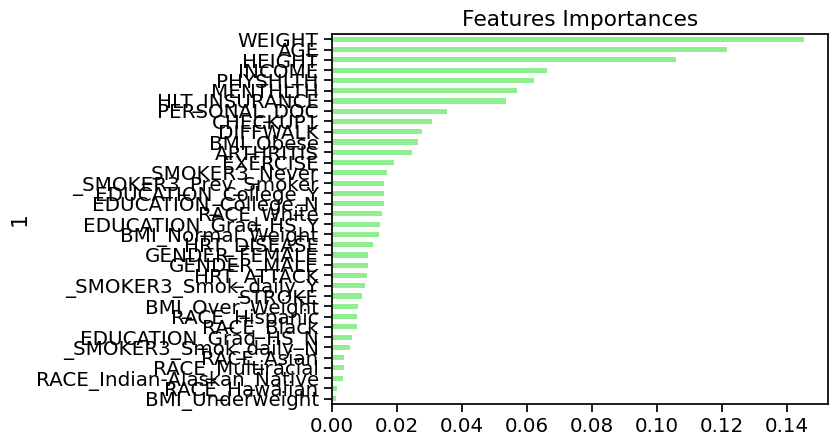

In [34]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, features.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

##### 3.1.3 Deep Learning Model

In [35]:
dim = features.shape[1]
dim

36

In [37]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="tanh", input_dim=dim))
nn_model.add(tf.keras.layers.Dense(units=16, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
1962/1962 [==============================] - 4s 2ms/step - loss: 0.5827 - accuracy: 0.6930
Epoch 2/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5702 - accuracy: 0.7039
Epoch 3/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5671 - accuracy: 0.7066
Epoch 4/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5651 - accuracy: 0.7070
Epoch 5/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5635 - accuracy: 0.7093
Epoch 6/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5627 - accuracy: 0.7087
Epoch 7/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5620 - accuracy: 0.7088
Epoch 8/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5614 - accuracy: 0.7108
Epoch 9/100
1962/1962 [==============================] - 3s 2ms/step - loss: 0.5610 - accuracy: 0.7099
Epoch 10/100
1962/1962 [==============================] - 3s 2ms/step - l

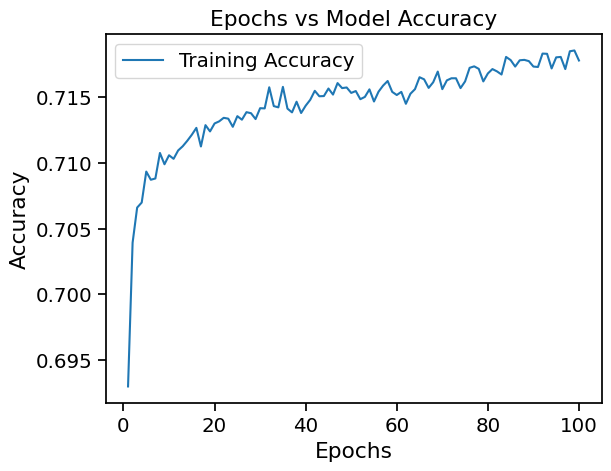

In [38]:
# extract accuracy values from the training history
train_accuracy = fit_model.history['accuracy']
epochs = range(1, len(train_accuracy) + 1)

# plot epochs vs accuracy
plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
plt.title('Epochs vs Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
nn_predictions = nn_model.predict(X_test_scaled)

654/654 [==============================] - 1s 1ms/step


In [42]:
binary_predictions = (nn_predictions > 0.5).astype(int)
binary_predictions

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [43]:
evaluate_model(y_test, binary_predictions, 'DNN', '50/50 Split')

Confusion Matrix
[[7102 3359]
 [2880 7580]]


Accuracy Score
0.7017828975670379


Classification Report
              precision    recall  f1-score   support

         0.0       0.71      0.68      0.69     10461
         1.0       0.69      0.72      0.71     10460

    accuracy                           0.70     20921
   macro avg       0.70      0.70      0.70     20921
weighted avg       0.70      0.70      0.70     20921





### 3.2 Using RandomOversampler

In [45]:
target = binary_df['DIABETES']
features = binary_df.drop(columns=['DIABETES'])

In [47]:
# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, stratify=target)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [50]:
# Initialize the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the random oversampling to the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)

# After oversampling
print("\nDistribution of classes after oversampling:")
print(pd.Series(y_train_resampled).value_counts())


Distribution of classes after oversampling:
0.0    153156
1.0    153156
Name: DIABETES, dtype: int64


##### 3.2.1 K-Nearest Neighbour Model


In [52]:
# Instantiate the model with k = 2 neighbors 
knn_model_ros = KNeighborsClassifier(n_neighbors = 2)

# Train the model
knn_model_ros.fit(X_train_resampled, y_train_resampled)

# Create predictions
y_pred_knn = knn_model_ros.predict(X_test_scaled)

In [53]:
evaluate_model(y_test, y_pred_knn, 'KNN', 'Oversampled Data')

Confusion Matrix
[[43791  7261]
 [ 7520  2941]]


Accuracy Score
0.7597093297351779


Classification Report
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86     51052
         1.0       0.29      0.28      0.28     10461

    accuracy                           0.76     61513
   macro avg       0.57      0.57      0.57     61513
weighted avg       0.76      0.76      0.76     61513





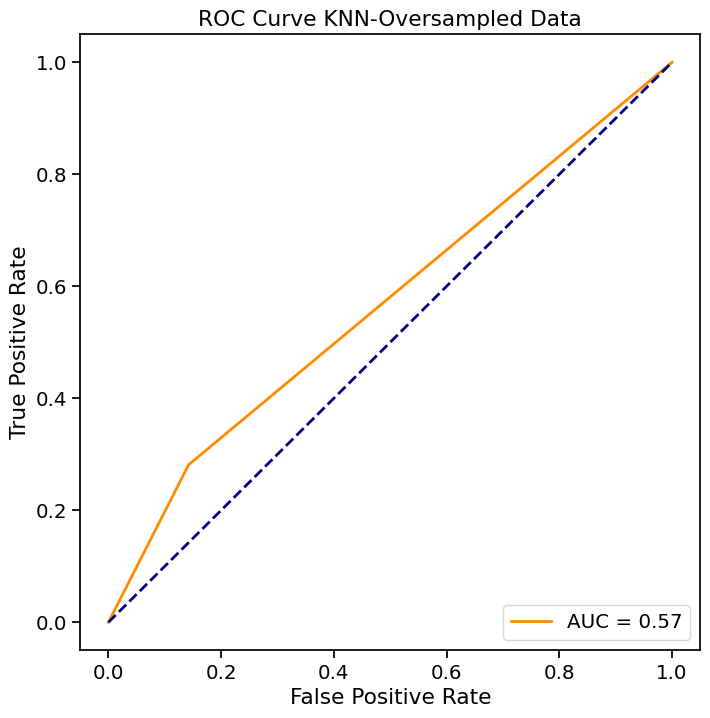

In [60]:
compute_ROC(y_test, y_pred_knn, 'KNN', 'Oversampled Data')

##### 3.2.2 Random Forest Model

In [55]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_resampled, y_train_resampled)

# Making predictions using the testing data
y_pred_rf_ros = rf_model.predict(X_test_scaled)

In [58]:
evaluate_model(y_test, y_pred_rf_ros, 'Random Forest', 'Oversampled Data')

Confusion Matrix
[[47324  3728]
 [ 7732  2729]]


Accuracy Score
0.8136979175133712


Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     51052
         1.0       0.42      0.26      0.32     10461

    accuracy                           0.81     61513
   macro avg       0.64      0.59      0.61     61513
weighted avg       0.79      0.81      0.80     61513





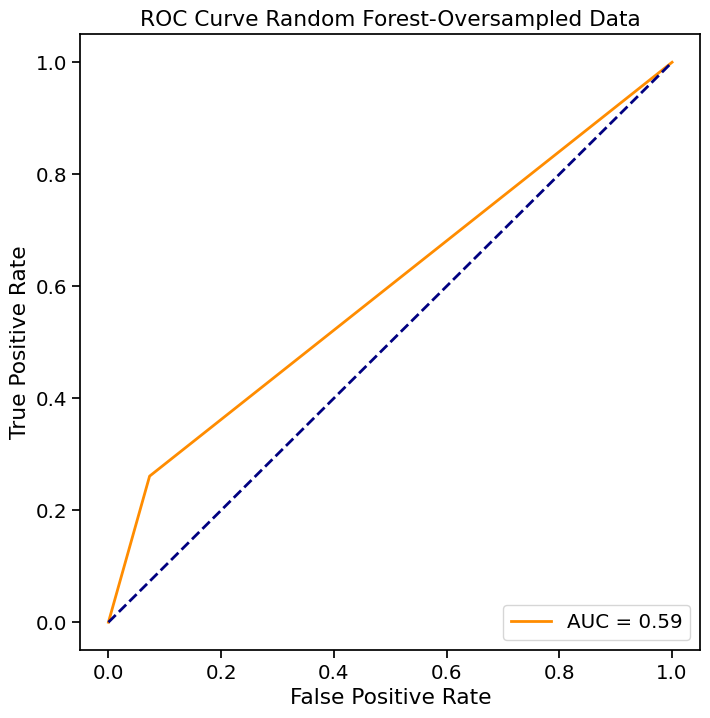

In [59]:
compute_ROC(y_test, y_pred_rf_ros, 'Random Forest', 'Oversampled Data')

##### 3.2.3 Deep Learning Model

In [61]:
dim_reduced = binary_df.shape[1]-1
dim_reduced

36

In [62]:
# Define the deep learning model 
nn_model_os = tf.keras.models.Sequential()
nn_model_os.add(tf.keras.layers.Dense(units=16, activation="tanh", input_dim=dim_reduced))
nn_model_os.add(tf.keras.layers.Dense(units=16, activation="tanh"))
nn_model_os.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model_os.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model_os = nn_model_os.fit(X_train_resampled, y_train_resampled, epochs=150)

Epoch 1/150
9573/9573 [==============================] - 17s 2ms/step - loss: 0.5698 - accuracy: 0.7046
Epoch 2/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5624 - accuracy: 0.7098
Epoch 3/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5604 - accuracy: 0.7110
Epoch 4/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5592 - accuracy: 0.7122
Epoch 5/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5584 - accuracy: 0.7122
Epoch 6/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5578 - accuracy: 0.7125
Epoch 7/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5573 - accuracy: 0.7129
Epoch 8/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5569 - accuracy: 0.7128
Epoch 9/150
9573/9573 [==============================] - 15s 2ms/step - loss: 0.5566 - accuracy: 0.7131
Epoch 10/150
9573/9573 [==============================] - 15s 2m

9573/9573 [==============================] - 18s 2ms/step - loss: 0.5498 - accuracy: 0.7183
Epoch 80/150
9573/9573 [==============================] - 18s 2ms/step - loss: 0.5497 - accuracy: 0.7184
Epoch 81/150
9573/9573 [==============================] - 17s 2ms/step - loss: 0.5498 - accuracy: 0.7189
Epoch 82/150
9573/9573 [==============================] - 19s 2ms/step - loss: 0.5498 - accuracy: 0.7189
Epoch 83/150
9573/9573 [==============================] - 18s 2ms/step - loss: 0.5497 - accuracy: 0.7186
Epoch 84/150
9573/9573 [==============================] - 18s 2ms/step - loss: 0.5496 - accuracy: 0.7193
Epoch 85/150
9573/9573 [==============================] - 18s 2ms/step - loss: 0.5496 - accuracy: 0.7185
Epoch 86/150
9573/9573 [==============================] - 17s 2ms/step - loss: 0.5496 - accuracy: 0.7189
Epoch 87/150
9573/9573 [==============================] - 17s 2ms/step - loss: 0.5496 - accuracy: 0.7190
Epoch 88/150
9573/9573 [==============================] - 17s 2ms/st

In [63]:
# Evaluate the model using the test data
model_loss_os, model_accuracy_os = nn_model_os.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss_os}, Accuracy: {model_accuracy_os}")

1923/1923 - 2s - loss: 0.5793 - accuracy: 0.6796 - 2s/epoch - 1ms/step
Loss: 0.5792508125305176, Accuracy: 0.6796449422836304


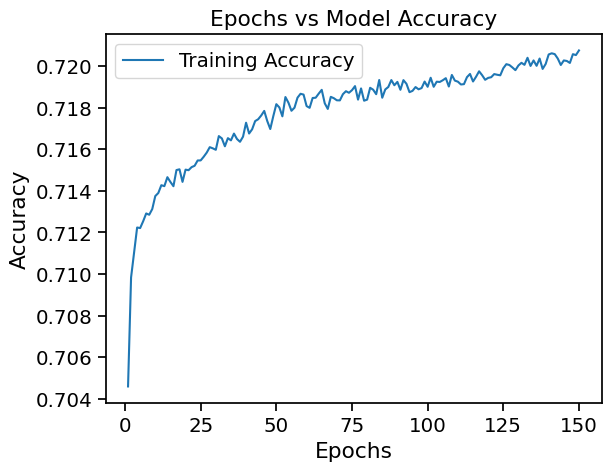

In [64]:
# extract accuracy values from the training history
train_accuracy_os = fit_model_os.history['accuracy']
epochs = range(1, len(train_accuracy_os) + 1)

# plot epochs vs accuracy
plt.plot(epochs, train_accuracy_os, label = 'Training Accuracy')
plt.title('Epochs vs Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
y_nn_pred_os = nn_model_os.predict(X_test_scaled)
y_pred_nn_os = np.round(y_nn_pred_os).flatten()

1923/1923 [==============================] - 2s 1ms/step


In [66]:
evaluate_model(y_test, y_pred_nn_os, 'DNN', 'Oversampled Data')

Confusion Matrix
[[34223 16829]
 [ 2877  7584]]


Accuracy Score
0.6796449530993448


Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.67      0.78     51052
         1.0       0.31      0.72      0.43     10461

    accuracy                           0.68     61513
   macro avg       0.62      0.70      0.61     61513
weighted avg       0.82      0.68      0.72     61513





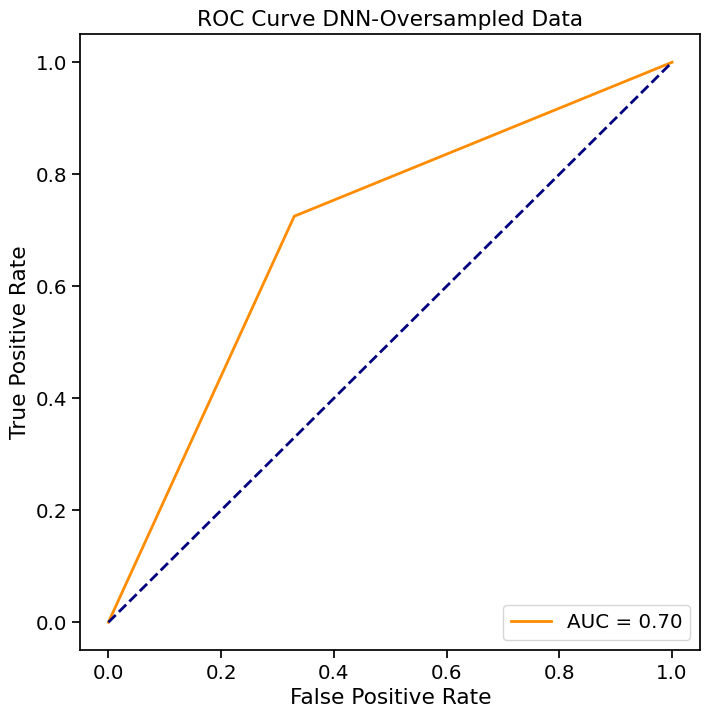

In [67]:
compute_ROC(y_test, y_pred_nn_os, 'DNN', 'Oversampled Data')

## 3.4 Model Comparison

In [68]:
model_data = {
    'Accuracy': accuracy_models,
    'Precision': precision_models,
    'F1 Score': F1score_models,
    'Recall': recall_models,
    'Model Type': model_type,
    'Resample': resample
}

model_comparison_df = pd.DataFrame(model_data)

In [70]:
model_comparison_df

,Accuracy,Precision,F1 Score,Recall,Model Type,Resample
0,0.611921,0.679167,0.522215,0.424187,KNN,50/50 Split
1,0.699871,0.687136,0.709722,0.733843,Random Forest,50/50 Split
2,0.701783,0.692934,0.708444,0.724665,DNN,50/50 Split
3,0.759709,0.288277,0.284663,0.281139,KNN,Oversampled Data
4,0.813698,0.422642,0.322615,0.260874,Random Forest,Oversampled Data
5,0.679645,0.310654,0.434937,0.724978,DNN,Oversampled Data


In [73]:
model_comparison_df[model_comparison_df['Model Type'] == 'DNN']

,Accuracy,Precision,F1 Score,Recall,Model Type,Resample
2,0.701783,0.692934,0.708444,0.724665,DNN,50/50 Split
5,0.679645,0.310654,0.434937,0.724978,DNN,Oversampled Data


Based on the quick analysis, it looks like the 50/50 data split has the high accuracy, precision, F1 score, and recall for the DNN model. Now we will optimize the DNN model to look for the optimal number of layers, neurons in each layer, and activiation function using hyperparameterization.

# 4 Model Optimization

##### 4.1 Keras Tuner

In [84]:
import os
import shutil

In [86]:
# Set the directory of the tuner
tuner_dir = '.'

# Clear the tuner directory
shutil.rmtree(tuner_dir, ignore_errors=True)
os.makedirs(tuner_dir, exist_ok=True)

In [87]:
import keras_tuner as kt

In [88]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=8,
        max_value=26,
        step=2), activation=activation, input_dim=dim_reduced))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=4,
            max_value=20,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [89]:
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [222]:
# splitting the data into a training and testing set
target_variable = new_diabetes_df['DIABETES']
features = new_diabetes_df.drop(columns = 'DIABETES')

# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, random_state=42, stratify=target_variable)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [91]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 01m 42s]
val_accuracy: 0.7092395424842834

Best val_accuracy So Far: 0.7120118737220764
Total elapsed time: 00h 42m 36s


In [92]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 12,
 'num_layers': 1,
 'units_0': 6,
 'units_1': 6,
 'units_2': 8,
 'units_3': 14,
 'units_4': 12,
 'units_5': 4,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [93]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

654/654 - 1s - loss: 0.5639 - accuracy: 0.7120 - 895ms/epoch - 1ms/step
Loss: 0.5638641119003296, Accuracy: 0.7120118737220764


In [94]:
y_pred_best_model = best_model.predict(X_test_scaled)
y_pred_best = np.round(y_pred_best_model).flatten()

654/654 [==============================] - 1s 1ms/step


In [95]:
evaluate_model(y_test, y_pred_best, 'DNN', 'Keras')

Confusion Matrix
[[7141 3320]
 [2705 7755]]


Accuracy Score
0.712011854117872


Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70     10461
         1.0       0.70      0.74      0.72     10460

    accuracy                           0.71     20921
   macro avg       0.71      0.71      0.71     20921
weighted avg       0.71      0.71      0.71     20921





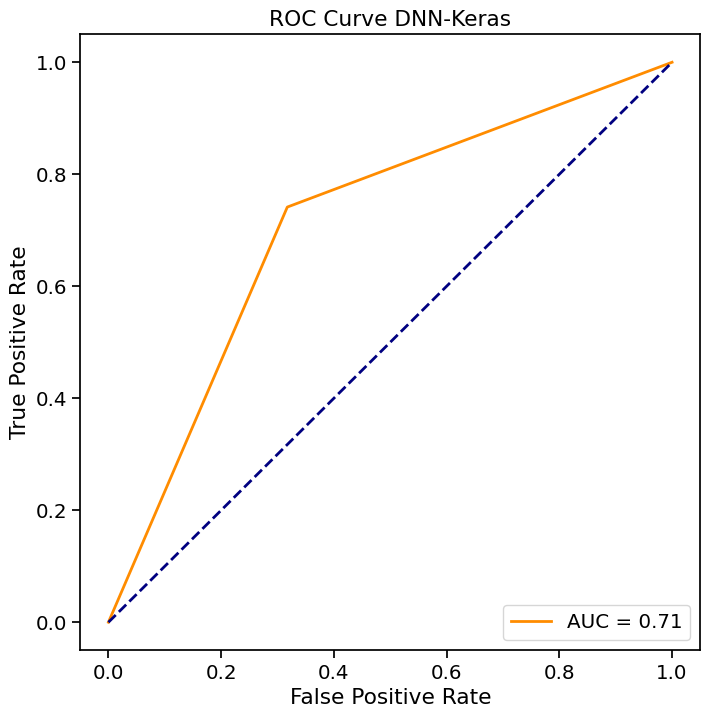

In [96]:
compute_ROC(y_test, y_pred_best, 'DNN', 'Keras')

##### 4.2 Random Forest Grid Search

In [206]:
new_diabetes_df.head()

,INCOME,WEIGHT,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,...,RACE_Hispanic,RACE_Indian-Alaskan_Native,RACE_Multiracial,RACE_White,_SMOKER3_Never,_SMOKER3_Prev_Smoker,_SMOKER3_Smok_daily_N,_SMOKER3_Smok_daily_Y,EDUCATION_College_N,EDUCATION_College_Y,EDUCATION_Grad_HS_N,EDUCATION_Grad_HS_Y
0,6.0,9072.0,10.0,0.0,0.0,20.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,1,1,0,0,0,1,0,0,0
1,6.0,7938.0,9.0,0.0,0.0,0.0,1.0,7.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1,0,0,1,0,0,0
2,7.0,6350.0,7.0,0.0,0.0,20.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,1,0,0
3,6.0,6123.0,9.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,1,0,0
4,7.0,9525.0,4.0,0.0,5.0,2.0,1.0,1.0,0.0,3.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,0,0,1


In [209]:
# splitting the data into a training and testing set
target_variable = new_diabetes_df['DIABETES']
features = new_diabetes_df.drop(columns = 'DIABETES')

# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, random_state=42, stratify=target_variable)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [207]:
# Define the parameter grid to search over
param_searchGrid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [208]:
# Create a random forest classifier object
rf_gridSearch = RandomForestClassifier(random_state=42)

In [212]:
grid_search = GridSearchCV(estimator=rf_gridSearch, param_grid=param_searchGrid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [213]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy score:  0.7051445478564132


# 5 Dropping More Features

In [151]:
reduced_df = classifier_data_2.copy()
reduced_df.head()

,Unnamed: 0,ID,STATE,GENDER,INCOME,WEIGHT,BMI,RACE,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,SLEEP,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,STROKE,ARTHRITIS,_SMOKER3,DIFFWALK,EDUCATION,HEIGHT
0,1,1,1.0,FEMALE,3.0,6804.0,Over_Weight,White,13.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,Never,0.0,Grad_HS_Y,63.0
1,2,2,1.0,FEMALE,6.0,6350.0,Over_Weight,White,8.0,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,Never,0.0,College_Y,62.0
2,4,4,1.0,FEMALE,3.0,5398.0,Normal_Weight,White,5.0,0.0,2.0,0.0,1.0,9.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,Never,0.0,College_N,62.0
3,6,6,1.0,FEMALE,5.0,6260.0,Normal_Weight,Black,13.0,0.0,0.0,0.0,1.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,Prev_Smoker,0.0,College_Y,65.0
4,7,7,1.0,FEMALE,5.0,7348.0,Over_Weight,White,13.0,0.0,0.0,0.0,0.0,8.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,Never,0.0,Grad_HS_Y,64.0


In [152]:
reduced_df._SMOKER3.value_counts()

Never           145572
Prev_Smoker      70603
Smok_daily_Y     21757
Smok_daily_N      8118
Name: _SMOKER3, dtype: int64

In [153]:
# Changing _SMOKER3
reduced_df['_SMOKER3'] = reduced_df['_SMOKER3'].replace({'Prev_Smoker':1, 'Smok_daily_Y':1, 'Smok_daily_N':1, "Never":0})
reduced_df._SMOKER3.value_counts()

0    145572
1    100478
Name: _SMOKER3, dtype: int64

In [154]:
reduced_df.BMI.value_counts()

Over_Weight      87776
Obese            86333
Normal_Weight    68506
Underweight       3435
Name: BMI, dtype: int64

In [155]:
# Changing BMI: 0 underweight, 1 normal, 2 overweight, 3 obese
reduced_df['BMI'] = reduced_df['BMI'].replace({'Over_Weight':2, 'Obese':3, 'Normal_Weight':1, "Underweight":0})
reduced_df.BMI.value_counts()

2    87776
3    86333
1    68506
0     3435
Name: BMI, dtype: int64

In [156]:
reduced_df.RACE.value_counts()

White                    188591
Hispanic                  21749
Black                     18158
Asian                      6696
Multiracial                5622
Indian-Alaskan_Native      3851
Hawaiian                   1383
Name: RACE, dtype: int64

In [157]:
# Changing RACE: 0 underweight, 1 normal, 2 overweight, 3 obese
reduced_df['RACE'] = reduced_df['RACE'].replace({'White':2, 'Hispanic':3, 'Black':1, "Asian":0, 'Multiracial':4, 'Indian-Alaskan_Native':5, 'Hawaiian':6})
reduced_df.RACE.value_counts()

2    188591
3     21749
1     18158
0      6696
4      5622
5      3851
6      1383
Name: RACE, dtype: int64

In [158]:
reduced_df.GENDER.value_counts()

FEMALE    126673
MALE      119377
Name: GENDER, dtype: int64

In [159]:
# Changing GENDER: 0 male, 1 female
reduced_df['GENDER'] = reduced_df['GENDER'].replace({'FEMALE':1, 'MALE':0})
reduced_df.GENDER.value_counts()

1    126673
0    119377
Name: GENDER, dtype: int64

In [160]:
reduced_df.EDUCATION.value_counts()

College_Y    112431
College_N     67903
Grad_HS_Y     55264
Grad_HS_N     10452
Name: EDUCATION, dtype: int64

In [161]:
# Changing EDUCATION: 0 Grad_HS_N, 1 Grad_HS_Y, 2 College_N, 3 College_Y
reduced_df['EDUCATION'] = reduced_df['EDUCATION'].replace({'Grad_HS_N':0, 'Grad_HS_Y':1, 'College_N':2, 'College_Y':3})
reduced_df.EDUCATION.value_counts()

3    112431
2     67903
1     55264
0     10452
Name: EDUCATION, dtype: int64

In [162]:
# modifying the weight column
reduced_df.WEIGHT = reduced_df.WEIGHT / 100
    
reduced_df.head()

,Unnamed: 0,ID,STATE,GENDER,INCOME,WEIGHT,BMI,RACE,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,SLEEP,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,STROKE,ARTHRITIS,_SMOKER3,DIFFWALK,EDUCATION,HEIGHT
0,1,1,1.0,1,3.0,68.04,2,2,13.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,63.0
1,2,2,1.0,1,6.0,63.50,2,2,8.0,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,3,62.0
2,4,4,1.0,1,3.0,53.98,1,2,5.0,0.0,2.0,0.0,1.0,9.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0,0.0,2,62.0
3,6,6,1.0,1,5.0,62.60,1,1,13.0,0.0,0.0,0.0,1.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,3,65.0
4,7,7,1.0,1,5.0,73.48,2,2,13.0,0.0,0.0,0.0,0.0,8.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,1,64.0


In [163]:
reduced_df.drop(columns=['Unnamed: 0','ID'], inplace=True)
reduced_df.head()

,STATE,GENDER,INCOME,WEIGHT,BMI,RACE,AGE,DIABETES,PHYSHLTH,MENTHLTH,EXERCISE,SLEEP,HLT_INSURANCE,PERSONAL_DOC,CHECKUP1,HRT_ATTACK,HRT_DISEASE,STROKE,ARTHRITIS,_SMOKER3,DIFFWALK,EDUCATION,HEIGHT
0,1.0,1,3.0,68.04,2,2,13.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,63.0
1,1.0,1,6.0,63.50,2,2,8.0,0.0,2.0,3.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,3,62.0
2,1.0,1,3.0,53.98,1,2,5.0,0.0,2.0,0.0,1.0,9.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0,0.0,2,62.0
3,1.0,1,5.0,62.60,1,1,13.0,0.0,0.0,0.0,1.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,3,65.0
4,1.0,1,5.0,73.48,2,2,13.0,0.0,0.0,0.0,0.0,8.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0.0,1,64.0


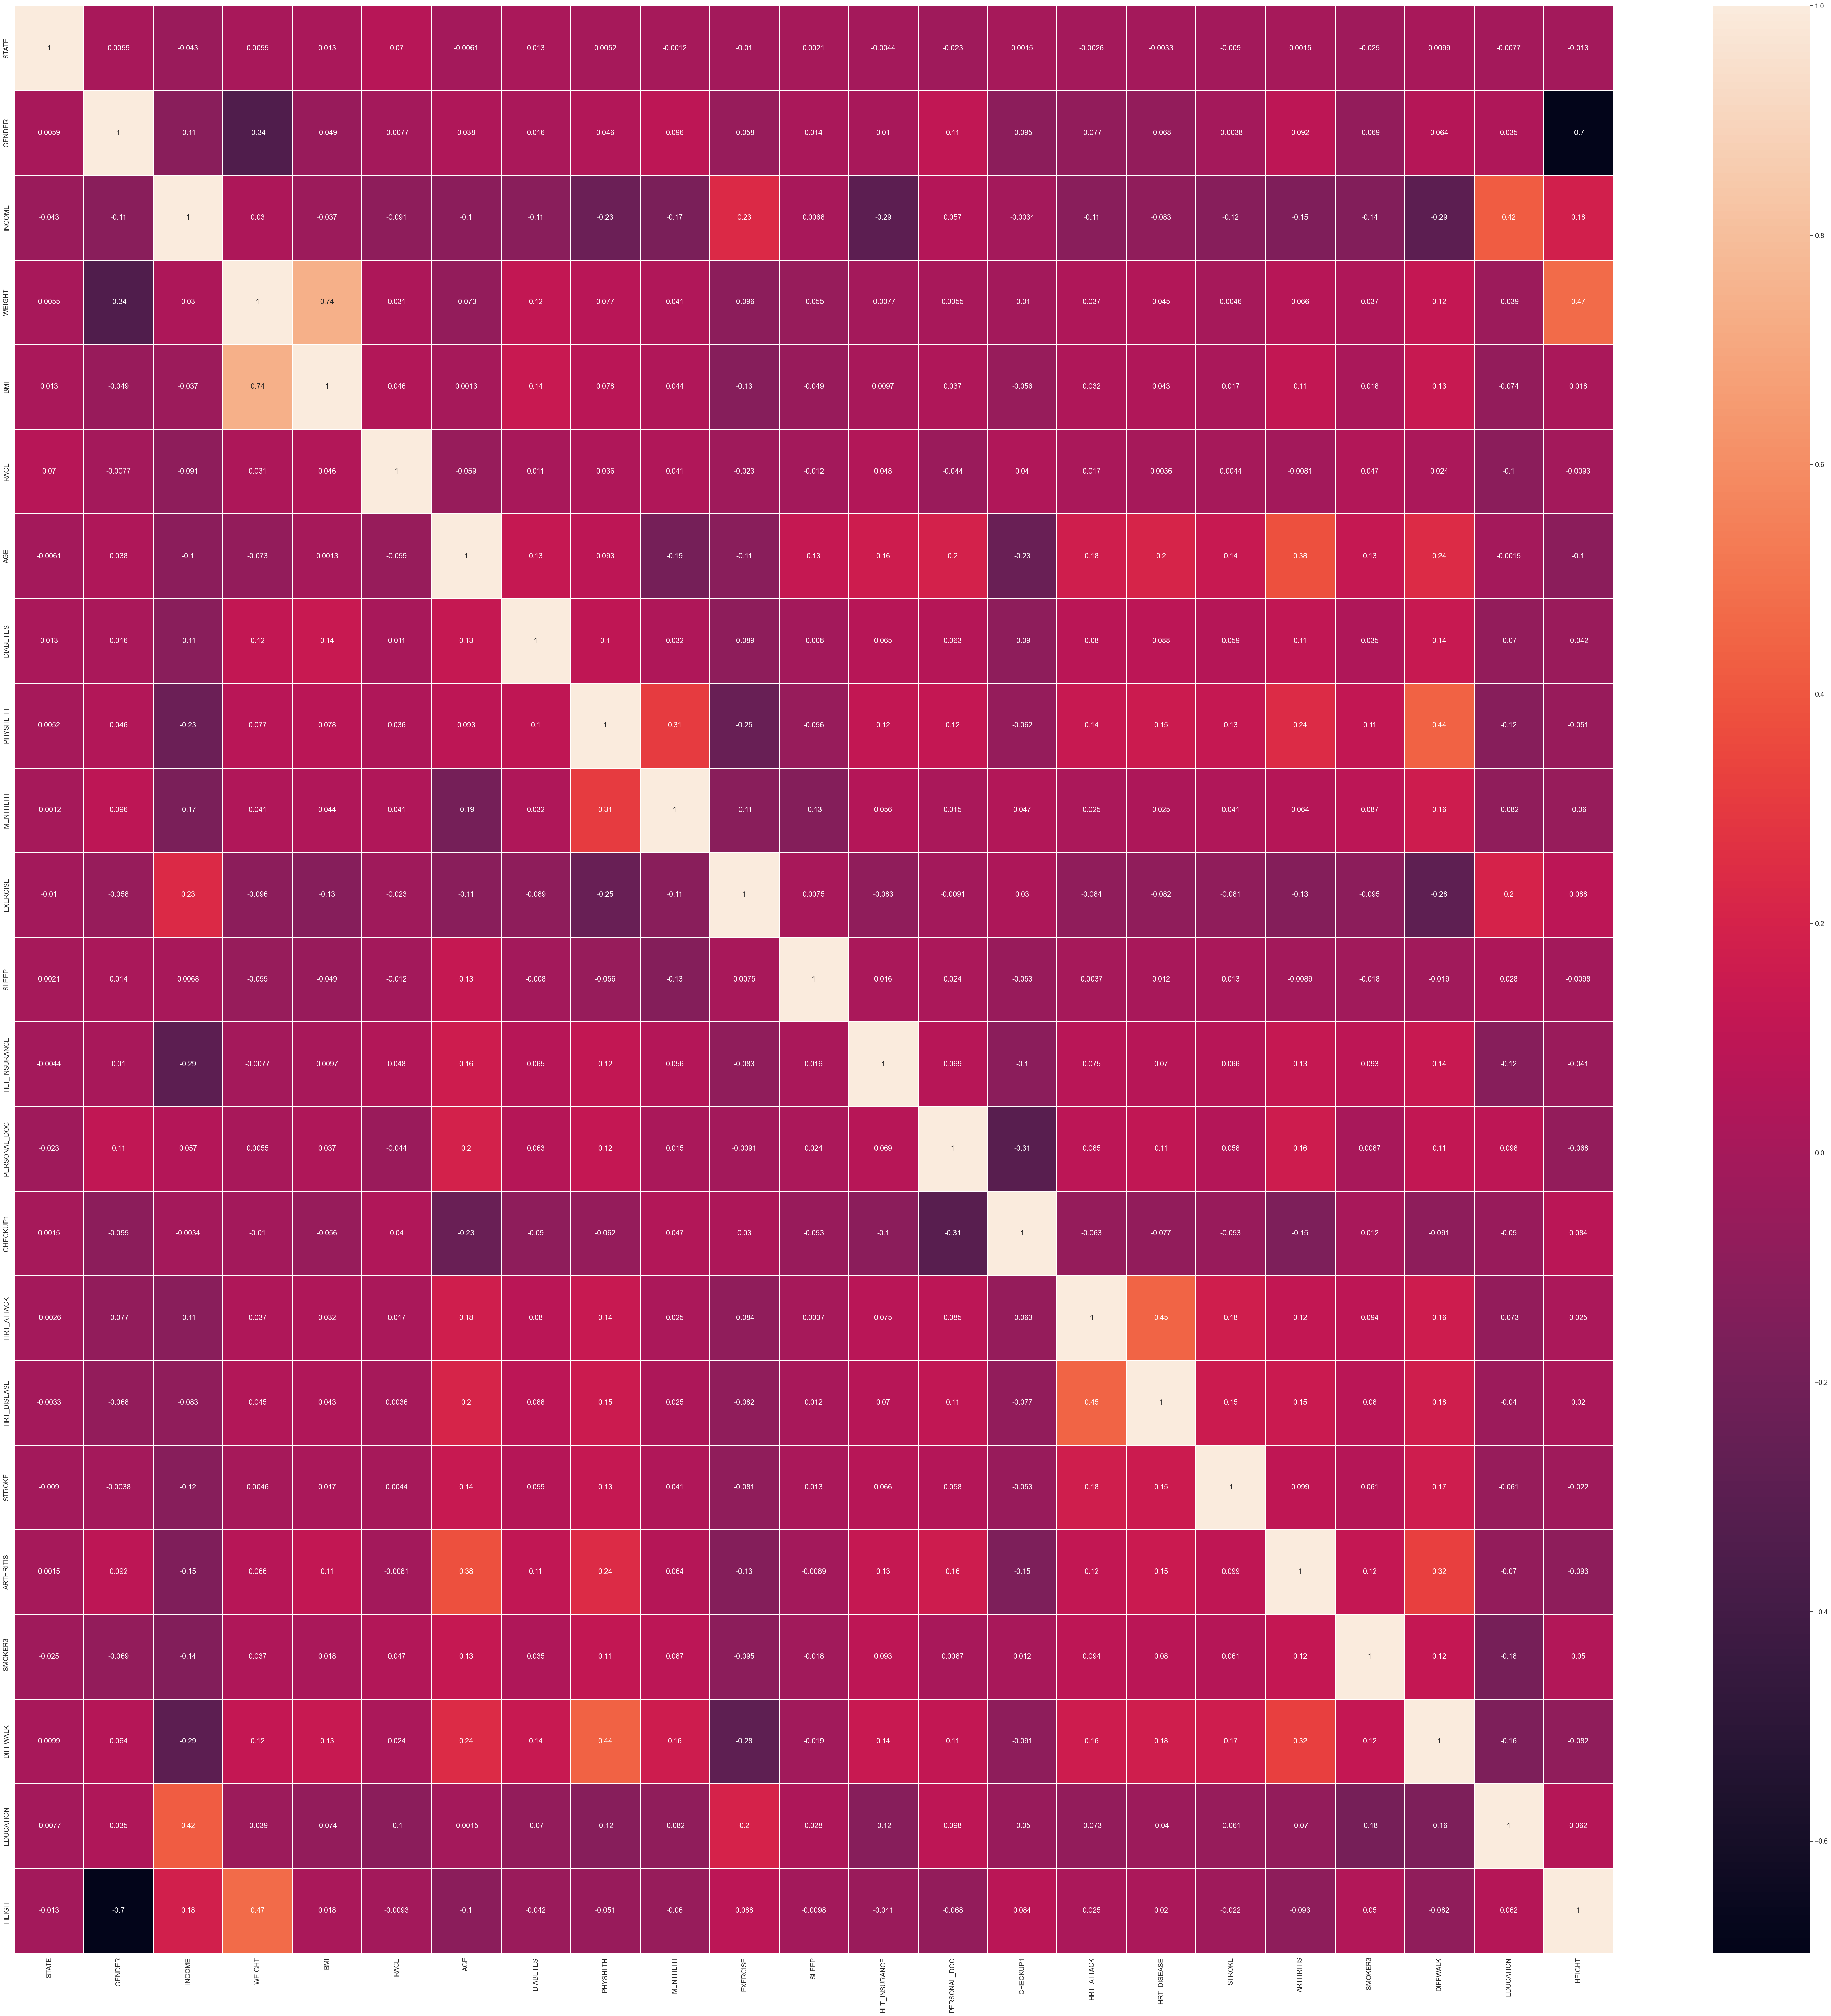

In [221]:
plt.figure(figsize=(60,60))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(reduced_df.corr(),annot=True,linewidth =2)
plt.tight_layout()

In [165]:
# calculate and display the correlation matrix
correlation_matrix = reduced_df.corr()
diabetes_corr_features = correlation_matrix['DIABETES']
diabetes_corr_features

STATE            0.012545
GENDER           0.015784
INCOME          -0.112232
WEIGHT           0.115456
BMI              0.140567
RACE             0.011486
AGE              0.128518
DIABETES         1.000000
PHYSHLTH         0.104078
MENTHLTH         0.032015
EXERCISE        -0.089386
SLEEP           -0.008007
HLT_INSURANCE    0.065222
PERSONAL_DOC     0.063193
CHECKUP1        -0.090279
HRT_ATTACK       0.079795
HRT_DISEASE      0.087732
STROKE           0.058638
ARTHRITIS        0.109642
_SMOKER3         0.035181
DIFFWALK         0.137010
EDUCATION       -0.069891
HEIGHT          -0.041721
Name: DIABETES, dtype: float64

In [166]:
cols_to_keep = ['INCOME','WEIGHT','BMI','AGE','PHYSHLTH','ARTHRITIS','DIFFWALK','DIABETES']
cleaned_df = reduced_df[cols_to_keep]
cleaned_df.head()

,INCOME,WEIGHT,BMI,AGE,PHYSHLTH,ARTHRITIS,DIFFWALK,DIABETES
0,3.0,68.04,2,13.0,0.0,0.0,0.0,0.0
1,6.0,63.50,2,8.0,2.0,0.0,0.0,0.0
2,3.0,53.98,1,5.0,2.0,0.0,0.0,0.0
3,5.0,62.60,1,13.0,0.0,0.0,0.0,0.0
4,5.0,73.48,2,13.0,0.0,1.0,0.0,0.0


In [171]:
cleaned_df['DIABETES'].value_counts()

0.0    204208
1.0     34006
4.0      5699
2.0      2137
Name: DIABETES, dtype: int64

In [173]:
# Changing DIABETES: 0 Grad_HS_N, 1 Grad_HS_Y, 2 College_N, 3 College_Y
cleaned_df['DIABETES'] = cleaned_df['DIABETES'].replace({4:1, 2:1})
cleaned_df.DIABETES.value_counts()

C:\Users\daian\AppData\Local\Temp\ipykernel_14192\3422228925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['DIABETES'] = cleaned_df['DIABETES'].replace({4:1, 2:1})


0.0    204208
1.0     41842
Name: DIABETES, dtype: int64

In [174]:
# separating the 0 and 1
diabetes = cleaned_df[cleaned_df['DIABETES'] == 1]
no_diabetes = cleaned_df[cleaned_df['DIABETES'] == 0]

# next we select 41,842 random entries from the 0 group since we have 41,842 entries of the 1 group
random_diabetes_selection = no_diabetes.take(np.random.permutation(len(no_diabetes))[:41842])

new_diabetes_df = random_diabetes_selection.append(diabetes, ignore_index=True)

new_diabetes_df.head()
new_diabetes_df.tail()

new_diabetes_df['DIABETES'].value_counts()

C:\Users\daian\AppData\Local\Temp\ipykernel_14192\955053756.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_diabetes_df = random_diabetes_selection.append(diabetes, ignore_index=True)


0.0    41842
1.0    41842
Name: DIABETES, dtype: int64

In [177]:
reduced_features = cleaned_df.drop(columns='DIABETES')
reduced_target = cleaned_df['DIABETES']

### 5.1 KNN Model

In [183]:
# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(reduced_features, reduced_target, random_state=42, stratify=reduced_target)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [179]:
# Instantiate the model with k = 2 neighbors 
knn_model_reduced = KNeighborsClassifier(n_neighbors = 2)

# Train the model
knn_model_reduced.fit(X_train_scaled, y_train)

# Create predictions
y_pred_knn_reduced = knn_model_reduced.predict(X_test_scaled)

In [180]:
evaluate_model(y_test, y_pred_knn_reduced, 'KNN', 'Reduced Features')

Confusion Matrix
[[49339  1713]
 [ 9494   967]]


Accuracy Score
0.817810869247151


Classification Report
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     51052
         1.0       0.36      0.09      0.15     10461

    accuracy                           0.82     61513
   macro avg       0.60      0.53      0.52     61513
weighted avg       0.76      0.82      0.77     61513





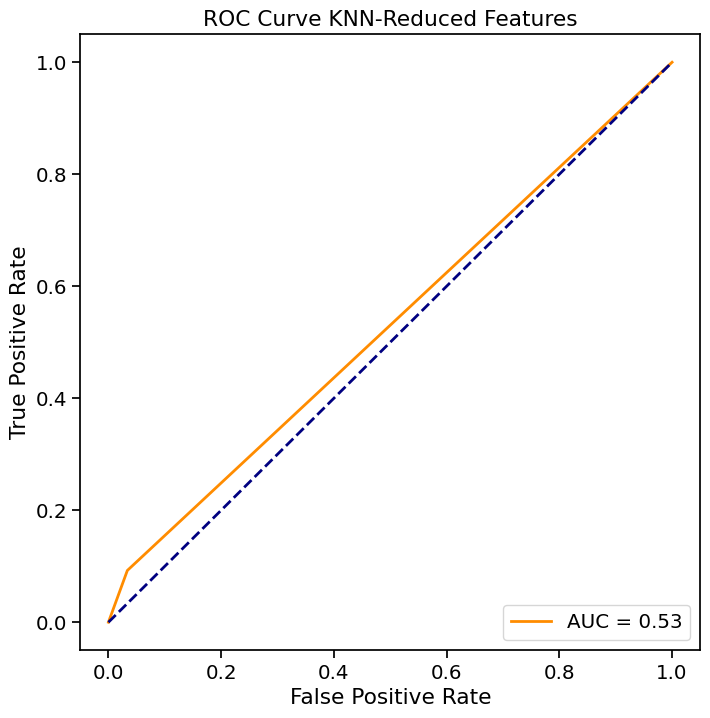

In [181]:
compute_ROC(y_test, y_pred_knn_reduced, 'KNN', 'Reduced Features')

##### Evaluating Model Performance

In [214]:
model_data = {
    'Accuracy': accuracy_models,
    'Precision': precision_models,
    'F1 Score': F1score_models,
    'Recall': recall_models,
    'Model Type': model_type,
    'Resample': resample
}

model_comparison_df = pd.DataFrame(model_data)
model_comparison_df

,Accuracy,Precision,F1 Score,Recall,Model Type,Resample
0,0.611921,0.679167,0.522215,0.424187,KNN,50/50 Split
1,0.699871,0.687136,0.709722,0.733843,Random Forest,50/50 Split
2,0.701783,0.692934,0.708444,0.724665,DNN,50/50 Split
3,0.759709,0.288277,0.284663,0.281139,KNN,Oversampled Data
4,0.813698,0.422642,0.322615,0.260874,Random Forest,Oversampled Data
5,0.679645,0.310654,0.434937,0.724978,DNN,Oversampled Data
6,0.712012,0.700226,0.720223,0.741396,DNN,Keras
7,0.817811,0.360821,0.147173,0.092439,KNN,Reduced Features


In [217]:
def graph_model_metrics(metric, df):
    # Set seaborn style for better aesthetics (optional but recommended)
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model Type", y=metric, hue="Resample", data=df, palette="viridis")

    # Set plot labels and title
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric}")
    plt.title(f"{metric} by Model Type and Resample")

    # Show the legend
    plt.legend(title="Resample", loc="upper left")

    # Show the plot
    plt.show()

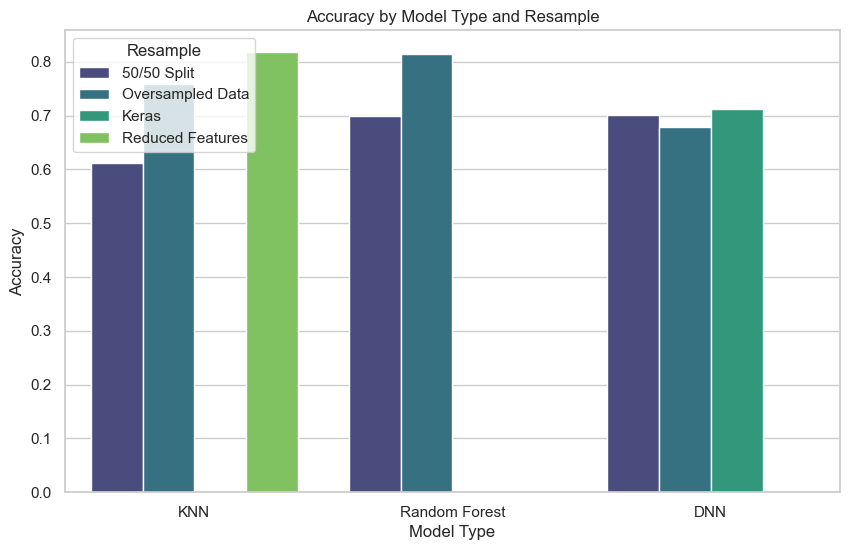

In [218]:
graph_model_metrics('Accuracy', model_comparison_df)

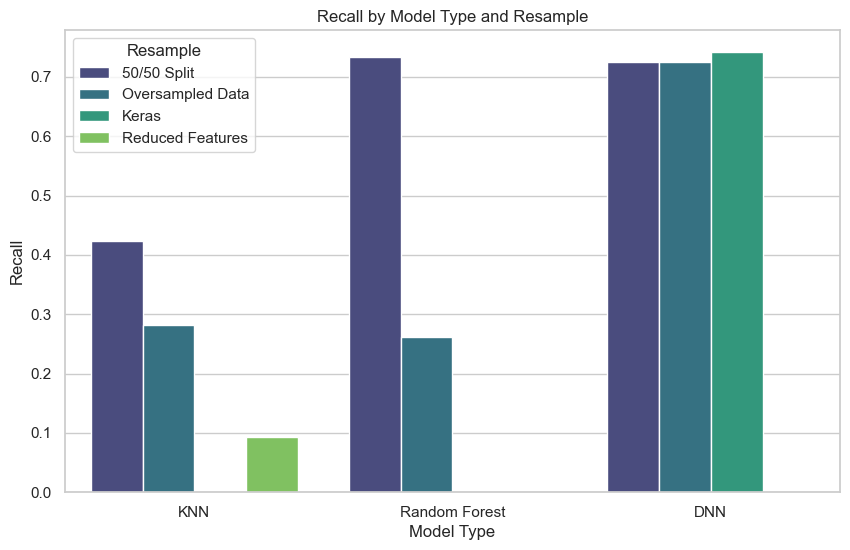

In [219]:
graph_model_metrics('Recall', model_comparison_df)

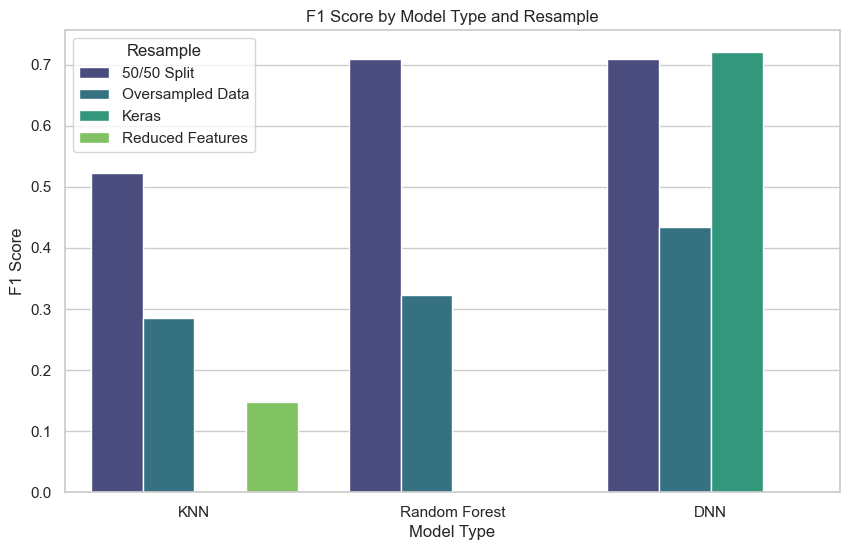

In [220]:
graph_model_metrics('F1 Score', model_comparison_df)